In [4]:
!pip install datasets afinn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53429 sha256=5f504abac4eb8071ca534ba5d976bcc70ea106e645d753855b09fb6d5d288c62
  Stored in directory: /root/.cache/pip/wheels/b0/05/90/43f79196199a138fb486902fceca30a2d1b5228e6d2db8eb90
Successfully built afinn


In [5]:
import nltk
import numpy as np
from nltk.tokenize import word_tokenize

nltk.download('punkt_tab')
from datasets import load_dataset
from tokenizers import ByteLevelBPETokenizer
from tqdm import tqdm

nltk.download('punkt')
import os
import random
from collections import defaultdict

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from afinn import Afinn
from sklearn.metrics import accuracy_score, f1_score
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from transformers import (AdamW, BertForSequenceClassification, BertTokenizer,
                          get_linear_schedule_with_warmup)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Part 0. Dataset Preparation

In [6]:
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.46k [00:00<?, ?B/s]

train.parquet:   0%|          | 0.00/699k [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [7]:
print(train_dataset[4])

{'text': "emerges as something rare , an issue movie that's so honest and keenly observed that it doesn't feel like one .", 'label': 1}


In [13]:
!pwd

/content


# Part 1. Preparing Word Embeddings

In [14]:
def load_glove_embeddings(filepath):
    embeddings_index = {}
    with open(filepath, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

In [15]:
def build_vocab(dataset):
    vocab = set()
    for sentence in dataset:
        tokens = word_tokenize(sentence['text'].lower())
        vocab.update(tokens)
    return vocab

In [16]:
def find_oov_words(vocab, embeddings):
    oovWords = [ word for word in vocab if word not in embeddings]
    return oovWords

In [20]:
glove_embeddings = load_glove_embeddings('/glove.6B.100d.txt')

### Part 1a) What is the size of the vocabulary formed from your training data?

In [21]:
vocab = build_vocab(train_dataset)
print(f'Size of vocabulary in training data: {len(vocab)}')

Size of vocabulary in training data: 18029


### Part 1b) How many OOV words exist in your training data?

In [22]:
oovWords = find_oov_words(vocab=vocab, embeddings=glove_embeddings)
print(f'Number of OOV words in training data: {len(oovWords)}')

Number of OOV words in training data: 2037


### Part 1c) OOV Strategies

#### Part 1ci) OOV Strategy 1: Random Embeddings

In [24]:
# Load the dataset
dataset = load_dataset("rotten_tomatoes")
train_raw = dataset['train']
validation_raw = dataset['validation']
test_raw = dataset['test']

# Build the vocabulary from training data
vocabulary = set()
for text in train_raw['text']:
    tokens = word_tokenize(text.lower())
    vocabulary.update(tokens)

# Add special tokens
vocabulary.add('<unk>')
vocabulary.add('<pad>')

# Create mappings between words and indices
word2idx = {word: idx for idx, word in enumerate(vocabulary)}
idx2word = {idx: word for word, idx in word2idx.items()}

# Initialize the embedding matrix
embedding_dim = 100  # Dimensionality of GloVe embeddings
vocab_size = len(word2idx)
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Load GloVe embeddings (ensure 'glove.6B.100d.txt' is in your working directory)
glove_path = '/glove.6B.100d.txt'  # Update the path if necessary
with open(glove_path, 'r', encoding='utf8') as f:
    for line in f:
        values = line.strip().split()
        if len(values) == embedding_dim + 1:
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            if word in word2idx:
                idx = word2idx[word]
                embedding_matrix[idx] = vector

# Set the embedding for '<pad>' token to zeros
pad_idx = word2idx['<pad>']
embedding_matrix[pad_idx] = np.zeros(embedding_dim)

#### Part 1cii) OOV Strategy 2: Byte-pair Encoding

In [25]:
# Load the Rotten Tomatoes dataset
dataset = load_dataset("rotten_tomatoes")
train_raw = dataset['train']
validation_raw = dataset['validation']
test_raw = dataset['test']

# Prepare the text data for BPE training
train_texts = [entry['text'] for entry in train_raw]

# Step 3: Initialize and Train the BPE Tokenizer
# Define a ByteLevelBPETokenizer instance
tokenizer = ByteLevelBPETokenizer()

# Train the tokenizer on the training texts
tokenizer.train_from_iterator(train_texts, vocab_size=30000, min_frequency=2)

# Save the trained tokenizer (optional)
tokenizer.save_model(".", "bpe_tokenizer")

# Step 4: Apply the Trained BPE Tokenizer to Your Datasets
# Tokenize a sample from the training set
train_tokenized = [tokenizer.encode(text).tokens for text in train_texts]

# Similarly tokenize the validation and test sets
validation_texts = [entry['text'] for entry in validation_raw]
validation_tokenized = [tokenizer.encode(text).tokens for text in validation_texts]

test_texts = [entry['text'] for entry in test_raw]
test_tokenized = [tokenizer.encode(text).tokens for text in test_texts]

# Print a sample tokenized text
print("Tokenized sample from training set:", train_tokenized[0])

Tokenized sample from training set: ['the', 'Ġrock', 'Ġis', 'Ġdestined', 'Ġto', 'Ġbe', 'Ġthe', 'Ġ21', 'st', 'Ġcentury', "'s", 'Ġnew', 'Ġ"', 'Ġconan', 'Ġ"', 'Ġand', 'Ġthat', 'Ġhe', "'s", 'Ġgoing', 'Ġto', 'Ġmake', 'Ġa', 'Ġsplash', 'Ġeven', 'Ġgreater', 'Ġthan', 'Ġarnold', 'Ġschwarzenegger', 'Ġ,', 'Ġjean', '-', 'cl', 'aud', 'Ġvan', 'Ġdamme', 'Ġor', 'Ġsteven', 'Ġse', 'gal', 'Ġ.']


In [26]:
def load_glove_embeddings(filepath):
    embeddings_index = {}
    with open(filepath, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

def get_subword_embedding(subwords, glove_embeddings, embedding_dim=100):
    vectors = []
    for subword in subwords:
        if subword in glove_embeddings:
            vectors.append(glove_embeddings[subword])
    if not vectors:
        # Handle the case where no subwords have embeddings
        return np.random.uniform(-0.05, 0.05, (embedding_dim,))
    # Average or sum the vectors
    return np.mean(vectors, axis=0)  # For averaging
    # return np.sum(vectors, axis=0)   # For summation

In [28]:
# Load the dataset
dataset = load_dataset("rotten_tomatoes")
train_raw = dataset['train']
validation_raw = dataset['validation']
test_raw = dataset['test']

# Build the vocabulary from training data
vocabulary = set()
for text in train_raw['text']:
    tokens = word_tokenize(text.lower())
    vocabulary.update(tokens)

# Add special tokens
vocabulary.add('<unk>')
vocabulary.add('<pad>')

# Create mappings between words and indices
word2idx = {word: idx for idx, word in enumerate(vocabulary)}
idx2word = {idx: word for word, idx in word2idx.items()}

# Initialize the embedding matrix
embedding_dim = 100  # Dimensionality of GloVe embeddings
vocab_size = len(word2idx)
embedding_matrix = np.random.uniform(-0.05, 0.05, (vocab_size, embedding_dim))

glove_embeddings = load_glove_embeddings('/glove.6B.100d.txt')
tokenizer = ByteLevelBPETokenizer.from_file("bpe_tokenizer-vocab.json", "bpe_tokenizer-merges.txt")

for word in word2idx:
    idx = word2idx[word]
    if word in glove_embeddings:
        vector = glove_embeddings[word]
        embedding_matrix[idx] = vector

    else:
        subwords = tokenizer.encode(word).tokens
        # print(subwords)
        vector = get_subword_embedding(subwords=subwords, glove_embeddings=glove_embeddings)
        embedding_matrix[idx] = vector


# Set the embedding for '<pad>' token to zeros
pad_idx = word2idx['<pad>']
embedding_matrix[pad_idx] = np.zeros(embedding_dim)

#### Part 1ci) OOV Strategy 3: Backoff and Interpolation

In [30]:

dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset['train']
vocabulary = set()

for text in train_dataset['text']:
    tokens = word_tokenize(text.lower())
    vocabulary.update(tokens)

# Print the size of the vocabulary
print("The size of the vocabulary is:", len(vocabulary))

glove_vocab = set()
glove_embeddings = {}
embedding_dim = 100
with open('/glove.6B.100d.txt', 'r', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        glove_vocab.add(word)
        glove_embeddings[word] = np.asarray(values[1:], dtype='float32')

# Identify OOV words
oov_words = vocabulary - glove_vocab

# Question 1(c): Handle OOV words using ngram and backoff and interpolation

from collections import defaultdict

vocabulary.add('<unk>')
vocabulary.add('<pad>')

# Create mappings between words and indices
word2idx = {word: idx for idx, word in enumerate(vocabulary)}
idx2word = {idx: word for idx, word in enumerate(vocabulary)}

# Initialize the embedding matrix for known words
embedding_matrix = np.zeros((len(vocabulary), embedding_dim))
for word in glove_vocab:
    if word in word2idx:  # Check if the word is in word2idx
        idx = word2idx[word]
        embedding_matrix[idx] = glove_embeddings[word]


# Create n-grams from training data
def create_ngrams(texts, n):
    ngram_counts = defaultdict(int)
    for entry in texts:  # Adjusted to iterate over each entry (dictionary)
        text = entry['text']  # Access the text with the appropriate key
        tokens = word_tokenize(text.lower())
        ngrams = zip(*[tokens[i:] for i in range(n)])  # Create n-grams
        for ngram in ngrams:
            ngram_counts[' '.join(ngram)] += 1
    return ngram_counts

# Create bigrams and trigrams
bigram_counts = create_ngrams(train_dataset, 2)  # Use train_raw directly
trigram_counts = create_ngrams(train_dataset, 3)  # Use train_raw directly

# Backoff and interpolation parameters
lambda1 = 0.8  # weight for unigrams
lambda2 = 0.15  # weight for bigrams
lambda3 = 0.05  # weight for trigrams

# Define a function for backoff and interpolation handling OOV words
def get_ngram_embedding(word, embedding_matrix, word2idx, bigram_counts, trigram_counts):
    if word in word2idx:
        return embedding_matrix[word2idx[word]]
    else:
        # Initialize embeddings for interpolation
        unigram_embedding = np.zeros(embedding_matrix.shape[1])
        bigram_embedding = np.zeros(embedding_matrix.shape[1])
        trigram_embedding = np.zeros(embedding_matrix.shape[1])

        # Check trigram context
        trigram_context = [ngram for ngram in trigram_counts if word in ngram.split()]
        if trigram_context:
            context_ngram = trigram_context[0].split()
            trigram_embedding = np.mean([embedding_matrix[word2idx[w]] for w in context_ngram if w in word2idx], axis=0)

        # Check bigram context
        bigram_context = [ngram for ngram in bigram_counts if word in ngram.split()]
        if bigram_context:
            context_ngram = bigram_context[0].split()
            bigram_embedding = np.mean([embedding_matrix[word2idx[w]] for w in context_ngram if w in word2idx], axis=0)

        # Calculate unigram embedding (mean of known embeddings, if available)
        known_words = [w for w in word2idx if w in vocabulary]
        if known_words:
            unigram_embedding = np.mean([embedding_matrix[word2idx[w]] for w in known_words if word2idx[w] < len(embedding_matrix)], axis=0)

        # Apply interpolation
        final_embedding = (lambda1 * unigram_embedding) + (lambda2 * bigram_embedding) + (lambda3 * trigram_embedding)
        return final_embedding

# Handle OOV words using n-gram embeddings
for oov_word in oov_words:
    if oov_word in word2idx:  # Ensure the OOV word exists in word2idx
        idx = word2idx[oov_word]
        embedding_matrix[idx] = get_ngram_embedding(oov_word, embedding_matrix, word2idx, bigram_counts, trigram_counts)

pad_idx = word2idx['<pad>']
embedding_matrix[pad_idx] = np.zeros(embedding_dim)

# Now, the embedding_matrix contains GloVe embeddings for known words and n-gram based embeddings for OOV words
print("Embedding matrix shape:", embedding_matrix.shape)

The size of the vocabulary is: 18029
Embedding matrix shape: (18031, 100)


# Part 2 RNN

In [31]:
# Define the RNN model using pre-trained embeddings
class SentimentRNN(nn.Module):
    def __init__(self, embedding_matrix):
        super(SentimentRNN, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze= True)
        self.lstm = nn.LSTM(embedding_dim, hidden_size=256, batch_first=True, bidirectional=False, num_layers=2, dropout=0.5)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        embeds = self.embedding(x)
        lstm_out, (h_n, c_n) = self.lstm(embeds)

        out, _ = torch.max(lstm_out, dim=1)
        # Concatenate the final hidden states from both directions
        # out = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)

        out = self.dropout(out)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = torch.sigmoid(self.fc2(out))
        return out.squeeze()

In [32]:
# Load the dataset
dataset = load_dataset("rotten_tomatoes")
train_raw = dataset['train']
validation_raw = dataset['validation']
test_raw = dataset['test']

# Build the vocabulary from training data
vocabulary = set()
for text in train_raw['text']:
    tokens = word_tokenize(text.lower())
    vocabulary.update(tokens)

# Add special tokens
vocabulary.add('<unk>')
vocabulary.add('<pad>')

# Create mappings between words and indices
word2idx = {word: idx for idx, word in enumerate(vocabulary)}
idx2word = {idx: word for word, idx in word2idx.items()}

# Initialize the embedding matrix
embedding_dim = 100  # Dimensionality of GloVe embeddings
vocab_size = len(word2idx)
# embedding_matrix = np.random.uniform(-0.05, 0.05, (vocab_size, embedding_dim))
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Load GloVe embeddings (ensure 'glove.6B.100d.txt' is in your working directory)
glove_path = '/glove.6B.100d.txt'  # Update the path if necessary
with open(glove_path, 'r', encoding='utf8') as f:
    for line in f:
        values = line.strip().split()
        if len(values) == embedding_dim + 1:
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            if word in word2idx:
                idx = word2idx[word]
                embedding_matrix[idx] = vector

# Set the embedding for '<pad>' token to zeros
pad_idx = word2idx['<pad>']
embedding_matrix[pad_idx] = np.zeros(embedding_dim)

In [33]:
# Define a function to convert sentences to indices
def sentence_to_indices(sentence, word2idx):
    tokens = word_tokenize(sentence.lower())
    indices = []
    for token in tokens:
        if token in word2idx:
            indices.append(word2idx[token])
        else:
            indices.append(word2idx['<unk>'])  # Map unknown words to '<unk>'
    return indices

# Define the collate_fn function for padding within batches
def collate_fn(batch):
    sequences = [item[0] for item in batch]
    labels = torch.tensor([item[1] for item in batch], dtype=torch.float)
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=word2idx['<pad>'])
    return sequences_padded, labels

In [34]:
# Define the custom Dataset class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, word2idx):
        self.texts = texts
        self.labels = labels
        self.word2idx = word2idx

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        indices = sentence_to_indices(text, self.word2idx)
        return torch.tensor(indices, dtype=torch.long), torch.tensor(label, dtype=torch.long)

In [35]:
def train_loop(model, device, optimizer, criterion, train_loader):
    model.train()
    running_loss = 0.0

    for sequences, labels in tqdm(train_loader):
        sequences = sequences.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)  # Gradient clipping
        optimizer.step()
        running_loss += loss.item() * sequences.size(0)
    epoch_loss = running_loss / len(train_dataset)
    return epoch_loss

In [36]:
def evaluate_model(model, val_loader, criterion, device):
    # Validation
    model.eval()
    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for sequences, labels in tqdm(val_loader):
            sequences = sequences.to(device)
            labels = labels.to(device)
            outputs = model(sequences)
            predicted = (outputs >= 0.5).long()

            #calculate val loss
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            correct += (predicted == labels.long()).sum().item()
            total += labels.size(0)
    val_accuracy = correct / total
    val_loss /= len(val_loader)
    return val_accuracy, val_loss

In [37]:
def train_model(model, model_name, num_epochs, optimizer, scheduler, criterion, patience, train_loader, val_loader, device):
    best_val_accuracy = 0
    best_val_loss = float('inf')
    epochs_no_improve = 0
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        epoch_loss = train_loop(model, device, optimizer, criterion, train_loader)
        train_losses.append(epoch_loss)

        # validation
        val_accuracy, val_loss = evaluate_model(model,val_loader, criterion , device)
        val_losses.append(val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Best Val Loss: {best_val_loss:.4f}')

        # Learning rate scheduling
        scheduler.step(val_accuracy)

        if val_loss <= best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            # Save the best model
            # return model
            torch.save(model.state_dict(), f'{model_name}_model.pt')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print('Early stopping!')

                break

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.xticks(range(1, len(train_losses) + 1))
    plt.legend()
    plt.show()

    return model

In [38]:
def test_model(model,device, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for sequences, labels in tqdm(test_loader):
            sequences = sequences.to(device)
            labels = labels.to(device)
            outputs = model(sequences)
            predicted = (outputs >= 0.5).long()
            correct += (predicted == labels.long()).sum().item()
            total += labels.size(0)
    test_accuracy = correct / total
    print(f'Accuracy Score on Test dataset: {test_accuracy:.4f}')

In [39]:
# Create datasets for training, validation, and testing
train_dataset = SentimentDataset(train_raw['text'], train_raw['label'], word2idx)
val_dataset = SentimentDataset(validation_raw['text'], validation_raw['label'], word2idx)
test_dataset = SentimentDataset(test_raw['text'], test_raw['label'], word2idx)

# Create DataLoaders for training, validation, and testing
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

### Part 2b: Report the accuracy score on the test set, as well as the accuracy score on the validation set for each epoch during training.

100%|██████████| 9/9 [00:02<00:00,  3.67it/s]


Epoch [1/30], Training Loss: 0.6558, Validation Accuracy: 0.7120, Validation Loss: 0.6031, Best Val Loss: inf


100%|██████████| 9/9 [00:03<00:00,  2.55it/s]


Epoch [2/30], Training Loss: 0.5455, Validation Accuracy: 0.7233, Validation Loss: 0.5344, Best Val Loss: 0.6031


100%|██████████| 9/9 [00:03<00:00,  2.74it/s]


Epoch [3/30], Training Loss: 0.5072, Validation Accuracy: 0.7580, Validation Loss: 0.5235, Best Val Loss: 0.5344


100%|██████████| 9/9 [00:03<00:00,  2.76it/s]


Epoch [4/30], Training Loss: 0.4965, Validation Accuracy: 0.7458, Validation Loss: 0.5196, Best Val Loss: 0.5235


100%|██████████| 9/9 [00:02<00:00,  3.68it/s]


Epoch [5/30], Training Loss: 0.4754, Validation Accuracy: 0.7542, Validation Loss: 0.5012, Best Val Loss: 0.5196


100%|██████████| 9/9 [00:02<00:00,  3.68it/s]


Epoch [6/30], Training Loss: 0.4701, Validation Accuracy: 0.7448, Validation Loss: 0.5050, Best Val Loss: 0.5012


100%|██████████| 9/9 [00:03<00:00,  2.58it/s]


Epoch [7/30], Training Loss: 0.4395, Validation Accuracy: 0.7645, Validation Loss: 0.4912, Best Val Loss: 0.5012


100%|██████████| 9/9 [00:02<00:00,  3.69it/s]


Epoch [8/30], Training Loss: 0.4266, Validation Accuracy: 0.7720, Validation Loss: 0.4919, Best Val Loss: 0.4912


100%|██████████| 9/9 [00:02<00:00,  3.70it/s]


Epoch [9/30], Training Loss: 0.4146, Validation Accuracy: 0.7720, Validation Loss: 0.4884, Best Val Loss: 0.4912


100%|██████████| 9/9 [00:02<00:00,  3.16it/s]


Epoch [10/30], Training Loss: 0.4103, Validation Accuracy: 0.7617, Validation Loss: 0.4958, Best Val Loss: 0.4884


100%|██████████| 9/9 [00:02<00:00,  3.64it/s]


Epoch [11/30], Training Loss: 0.3960, Validation Accuracy: 0.7533, Validation Loss: 0.4869, Best Val Loss: 0.4884


100%|██████████| 9/9 [00:02<00:00,  3.05it/s]


Epoch [12/30], Training Loss: 0.3766, Validation Accuracy: 0.7795, Validation Loss: 0.4845, Best Val Loss: 0.4869


100%|██████████| 9/9 [00:03<00:00,  2.88it/s]


Epoch [13/30], Training Loss: 0.3670, Validation Accuracy: 0.7627, Validation Loss: 0.4887, Best Val Loss: 0.4845


100%|██████████| 9/9 [00:02<00:00,  3.67it/s]


Epoch [14/30], Training Loss: 0.3587, Validation Accuracy: 0.7636, Validation Loss: 0.4918, Best Val Loss: 0.4845


100%|██████████| 9/9 [00:02<00:00,  3.68it/s]


Epoch [15/30], Training Loss: 0.3506, Validation Accuracy: 0.7702, Validation Loss: 0.5111, Best Val Loss: 0.4845


100%|██████████| 9/9 [00:03<00:00,  2.96it/s]


Epoch [16/30], Training Loss: 0.3316, Validation Accuracy: 0.7674, Validation Loss: 0.5048, Best Val Loss: 0.4845


100%|██████████| 9/9 [00:02<00:00,  3.69it/s]


Epoch [17/30], Training Loss: 0.3249, Validation Accuracy: 0.7598, Validation Loss: 0.5311, Best Val Loss: 0.4845
Early stopping!


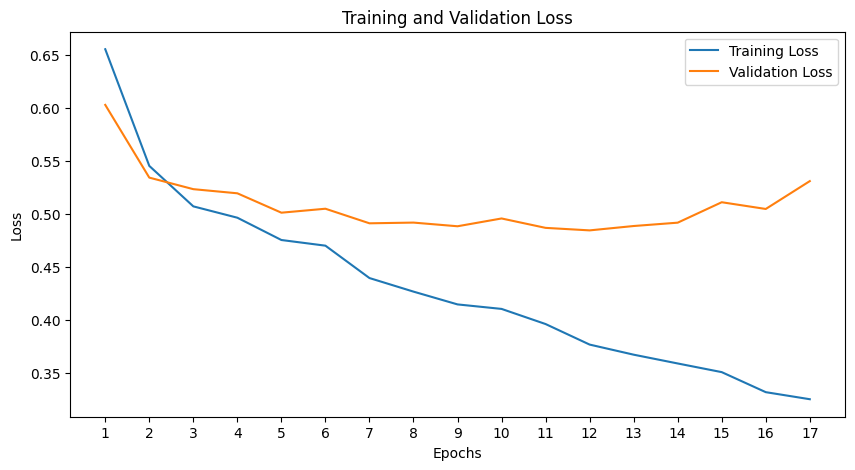

SentimentRNN(
  (embedding): Embedding(18031, 100)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
)

In [40]:
# Instantiate the model
rnn_model = SentimentRNN(embedding_matrix)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rnn_model.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5, verbose=True)

# Training loop with validation and early stopping
num_epochs = 30
patience = 5  # Early stopping patience

train_model(rnn_model, 'rnn', num_epochs, optimizer, scheduler, criterion, patience, train_loader, val_loader, device)

In [41]:
# Load the best model and evaluate on the test set
rnn_model.load_state_dict(torch.load('rnn_model.pt'))
test_model(rnn_model,device, test_loader)

<ipython-input-41-f7d08250d7d6>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rnn_model.load_state_dict(torch.load('rnn_model.pt'))
100%|██████████| 9/9 [00:03<00:00,  2.

Accuracy Score on Test dataset: 0.7777


## Part 2c) Methods used in deriving the final sentence representation

### Part 2c.1) Method 1: Max-Pooling

In [42]:
class SentimentRNNWithMaxPooling(nn.Module):
    def __init__(self, embedding_matrix):
        super(SentimentRNNWithMaxPooling, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=True)
        self.lstm = nn.LSTM(embedding_dim, hidden_size=256, batch_first=True, bidirectional=False, num_layers=2, dropout=0.5)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        embeds = self.embedding(x)
        lstm_out, _ = self.lstm(embeds)

        max_pool, _ = torch.max(lstm_out, dim = 1) #Considers the maximum output of all analyzed LSTM layers to determine the final result.

        out = self.dropout(max_pool)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = torch.sigmoid(self.fc2(out))
        return out.squeeze()

In [ ]:
# Instantiate the model
rnn_model = SentimentRNNWithMaxPooling(embedding_matrix)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rnn_model.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5, verbose=True)

# Training loop with validation and early stopping
num_epochs = 30
patience = 5  # Early stopping patience

train_model(rnn_model, 'maxpooling', num_epochs, optimizer, scheduler, criterion, patience, train_loader, val_loader, device)

100%|██████████| 9/9 [00:02<00:00,  3.72it/s]


Epoch [1/30], Training Loss: 0.6549, Validation Accuracy: 0.6970, Validation Loss: 0.6112, Best Val Loss: inf


100%|██████████| 9/9 [00:02<00:00,  3.57it/s]


Epoch [2/30], Training Loss: 0.5677, Validation Accuracy: 0.7083, Validation Loss: 0.5418, Best Val Loss: 0.6112


100%|██████████| 9/9 [00:03<00:00,  2.63it/s]


Epoch [3/30], Training Loss: 0.5290, Validation Accuracy: 0.7448, Validation Loss: 0.5311, Best Val Loss: 0.5418


100%|██████████| 9/9 [00:02<00:00,  3.69it/s]


Epoch [4/30], Training Loss: 0.5101, Validation Accuracy: 0.7664, Validation Loss: 0.5073, Best Val Loss: 0.5311


100%|██████████| 9/9 [00:02<00:00,  3.68it/s]


Epoch [5/30], Training Loss: 0.4819, Validation Accuracy: 0.7448, Validation Loss: 0.4930, Best Val Loss: 0.5073


100%|██████████| 9/9 [00:02<00:00,  3.44it/s]


Epoch [6/30], Training Loss: 0.4657, Validation Accuracy: 0.7608, Validation Loss: 0.4926, Best Val Loss: 0.4930


100%|██████████| 9/9 [00:02<00:00,  3.43it/s]


Epoch [7/30], Training Loss: 0.4560, Validation Accuracy: 0.7692, Validation Loss: 0.4899, Best Val Loss: 0.4926


100%|██████████| 9/9 [00:02<00:00,  3.66it/s]


Epoch [8/30], Training Loss: 0.4465, Validation Accuracy: 0.7580, Validation Loss: 0.4847, Best Val Loss: 0.4899


100%|██████████| 9/9 [00:02<00:00,  3.63it/s]


Epoch [9/30], Training Loss: 0.4339, Validation Accuracy: 0.7702, Validation Loss: 0.4769, Best Val Loss: 0.4847


100%|██████████| 9/9 [00:03<00:00,  2.48it/s]


Epoch [10/30], Training Loss: 0.4182, Validation Accuracy: 0.7833, Validation Loss: 0.4970, Best Val Loss: 0.4769


100%|██████████| 9/9 [00:02<00:00,  3.64it/s]


Epoch [11/30], Training Loss: 0.4063, Validation Accuracy: 0.7730, Validation Loss: 0.4762, Best Val Loss: 0.4769


100%|██████████| 9/9 [00:02<00:00,  3.63it/s]


Epoch [12/30], Training Loss: 0.3963, Validation Accuracy: 0.7645, Validation Loss: 0.4715, Best Val Loss: 0.4762


100%|██████████| 9/9 [00:03<00:00,  2.53it/s]


Epoch [13/30], Training Loss: 0.3769, Validation Accuracy: 0.7758, Validation Loss: 0.4855, Best Val Loss: 0.4715


 78%|███████▊  | 7/9 [00:02<00:00,  3.32it/s]

In [ ]:
# Load the best model and evaluate on the test set
rnn_model.load_state_dict(torch.load('maxpooling_model.pt'))
test_model(rnn_model,device, test_loader)

### Part 2c.2) Method 2: Mean-Pooling

In [ ]:
class SentimentRNNWithAvgPooling(nn.Module):
    def __init__(self, embedding_matrix):
        super(SentimentRNNWithAvgPooling, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=True)
        self.lstm = nn.LSTM(embedding_dim, hidden_size=256, batch_first=True, bidirectional=False, num_layers=2, dropout=0.5)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        embeds = self.embedding(x)
        lstm_out, _ = self.lstm(embeds)

        mean_pool= lstm_out.mean(dim = 1) #Considers the mean output of all analyzed LSTM layers to determine the final result.

        out = self.dropout(mean_pool)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = torch.sigmoid(self.fc2(out))
        return out.squeeze()

In [ ]:
# Instantiate the model
rnn_model = SentimentRNNWithAvgPooling(embedding_matrix)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rnn_model.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5, verbose=True)

# Training loop with validation and early stopping
num_epochs = 30
patience = 5  # Early stopping patience

train_model(rnn_model, 'meanpooling', num_epochs, optimizer, scheduler, criterion, patience, train_loader, val_loader, device)

In [ ]:
# Load the best model and evaluate on the test set
rnn_model.load_state_dict(torch.load('meanpooling_model.pt'))
test_model(rnn_model,device, test_loader)

### Part 2c.3) Method 3: Simple Attention Mechanism

In [ ]:
class SimpleAttention(nn.Module):
  def __init__(self, hidden_size):
      super(SimpleAttention, self).__init__()
      self.weight = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
      self.bias = nn.Parameter(torch.Tensor(hidden_size))

  def forward(self, hidden_states):
      # hidden_states: [batch_size, seq_len, hidden_size]
      batch_size, seq_len, hidden_size = hidden_states.size()

      # Calculate attention weights
      weights = torch.bmm(hidden_states, self.weight.unsqueeze(0).repeat(batch_size, 1, 1))
      weights = torch.tanh(weights + self.bias.unsqueeze(0).unsqueeze(1).repeat(batch_size, seq_len, 1))
      weights = torch.softmax(weights, dim=1)  # Normalize weights

      # Weight the hidden states
      weighted_hidden_states = hidden_states * weights

      # Aggregate the weighted hidden states
      context_vector = torch.sum(weighted_hidden_states, dim=1)  # Sum across time steps

      return context_vector


# Define the RNN model using pre-trained embeddings
class SentimentRNNWithSimpleAttention(nn.Module):
    def __init__(self, embedding_matrix):
        super(SentimentRNNWithSimpleAttention, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=True)
        self.lstm = nn.LSTM(embedding_dim, hidden_size=256, batch_first=True, bidirectional=False, num_layers=2, dropout=0.5)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        self.attention = SimpleAttention(hidden_size=256)

    def forward(self, x):
        embeds = self.embedding(x)
        lstm_out, (h_n, c_n) = self.lstm(embeds)

        # Apply Attention Mechanism
        context_vector = self.attention(lstm_out)

        context_vector = self.dropout(context_vector)
        context_vector = self.relu(self.fc1(context_vector))
        context_vector = self.dropout(context_vector)
        context_vector = torch.sigmoid(self.fc2(context_vector))
        return context_vector.squeeze()

In [ ]:
# Instantiate the model
rnn_model = SentimentRNNWithSimpleAttention(embedding_matrix)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rnn_model.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5, verbose=True)

# Training loop with validation and early stopping
num_epochs = 30
patience = 5  # Early stopping patience

train_model(rnn_model, 'simpleattention', num_epochs, optimizer, scheduler, criterion, patience, train_loader, val_loader, device)

In [ ]:
# Load the best model and evaluate on the test set
rnn_model.load_state_dict(torch.load('simpleattention_model.pt'))
test_model(rnn_model,device, test_loader)

### Part 2c.4) Method 4: Self-Attention Mechanism

In [ ]:
class SelfAttention(nn.Module):
  def __init__(self, hidden_size):
      super(SelfAttention, self).__init__()
      self.query = nn.Linear(hidden_size, hidden_size)  # Linear layer for query
      self.key = nn.Linear(hidden_size, hidden_size)    # Linear layer for key
      self.value = nn.Linear(hidden_size, hidden_size)  # Linear layer for value

  def forward(self, hidden_states):
      # hidden_states: [batch_size, seq_len, hidden_size]
      batch_size, seq_len, hidden_size = hidden_states.size()

      # Calculate vectors
      Q = self.query(hidden_states)
      K = self.key(hidden_states)
      V = self.value(hidden_states)

      # Calculate attention weights
      attention_weights = torch.bmm(Q, K.transpose(1, 2)) / (hidden_size ** 0.5)
      attention_weights = torch.softmax(attention_weights, dim=-1)

      # Weight the value vectors by attention weights
      weighted_values = torch.bmm(attention_weights, V)

      return weighted_values

class SimpleAttention(nn.Module):
  def __init__(self, hidden_size):
      super(SimpleAttention, self).__init__()
      self.weight = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
      self.bias = nn.Parameter(torch.Tensor(hidden_size))

  def forward(self, hidden_states):
      # hidden_states: [batch_size, seq_len, hidden_size]
      batch_size, seq_len, hidden_size = hidden_states.size()

      # Calculate attention weights
      weights = torch.bmm(hidden_states, self.weight.unsqueeze(0).repeat(batch_size, 1, 1))
      weights = torch.tanh(weights + self.bias.unsqueeze(0).unsqueeze(1).repeat(batch_size, seq_len, 1))
      weights = torch.softmax(weights, dim=1)  # Normalize weights

      # Weight the hidden states
      weighted_hidden_states = hidden_states * weights

      # Aggregate the weighted hidden states
      context_vector = torch.sum(weighted_hidden_states, dim=1)  # Sum across time steps

      return context_vector


# Define the RNN model using pre-trained embeddings
class SentimentRNNWithSelfAttention(nn.Module):
    def __init__(self, embedding_matrix):
        super(SentimentRNNWithSelfAttention, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=True)
        self.lstm = nn.LSTM(embedding_dim, hidden_size=256, batch_first=True, bidirectional=False, num_layers=2, dropout=0.5)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        self.self_attention = SelfAttention(hidden_size=256)
        self.simple_attention = SimpleAttention(hidden_size=256)

    def forward(self, x):
        embeds = self.embedding(x)
        lstm_out, (h_n, c_n) = self.lstm(embeds)

        # Apply self-attention
        self_attention_out = self.self_attention(lstm_out)

        # Apply Simple attention
        context_vector = self.simple_attention(self_attention_out)

        context_vector = self.dropout(context_vector)
        context_vector = self.relu(self.fc1(context_vector))
        context_vector = self.dropout(context_vector)
        context_vector = torch.sigmoid(self.fc2(context_vector))
        return context_vector.squeeze()

In [ ]:
# Instantiate the model
rnn_model = SentimentRNNWithSelfAttention(embedding_matrix)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rnn_model.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5, verbose=True)

# Training loop with validation and early stopping
num_epochs = 30
patience = 5  # Early stopping patience

train_model(rnn_model, 'selfattention', num_epochs, optimizer, scheduler, criterion, patience, train_loader, val_loader, device)

In [ ]:
# Load the best model and evaluate on the test set
rnn_model.load_state_dict(torch.load('selfattention_model.pt'))
test_model(rnn_model,device, test_loader)

# Part 3 Enhancement

## Part 3.1 Word Embeddings Updated

In [ ]:
# Load the dataset
dataset = load_dataset("rotten_tomatoes")
train_raw = dataset['train']
validation_raw = dataset['validation']
test_raw = dataset['test']

# Build the vocabulary from training data
vocabulary = set()
for text in train_raw['text']:
    tokens = word_tokenize(text.lower())
    vocabulary.update(tokens)

# Add special tokens
vocabulary.add('<unk>')
vocabulary.add('<pad>')

# Create mappings between words and indices
word2idx = {word: idx for idx, word in enumerate(vocabulary)}
idx2word = {idx: word for word, idx in word2idx.items()}

# Initialize the embedding matrix
embedding_dim = 100  # Dimensionality of GloVe embeddings
vocab_size = len(word2idx)
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Load GloVe embeddings (ensure 'glove.6B.100d.txt' is in your working directory)
glove_path = '/glove.6B.100d.txt'  # Update the path if necessary
with open(glove_path, 'r', encoding='utf8') as f:
    for line in f:
        values = line.strip().split()
        if len(values) == embedding_dim + 1:
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            if word in word2idx:
                idx = word2idx[word]
                embedding_matrix[idx] = vector

# Set the embedding for '<pad>' token to zeros
pad_idx = word2idx['<pad>']
embedding_matrix[pad_idx] = np.zeros(embedding_dim)

In [ ]:
# Define the RNN model using pre-trained embeddings
class SentimentRNNUpdatedEmbeddings(nn.Module):
    def __init__(self, embedding_matrix):
        super(SentimentRNNUpdatedEmbeddings, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze= False)
        self.lstm = nn.LSTM(embedding_dim, hidden_size=256, batch_first=True, bidirectional=False, num_layers=2, dropout=0.5)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        embeds = self.embedding(x)
        lstm_out, (h_n, c_n) = self.lstm(embeds)

        out, _ = torch.max(lstm_out, dim=1)
        # Concatenate the final hidden states from both directions
        # out = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)

        out = self.dropout(out)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = torch.sigmoid(self.fc2(out))
        return out.squeeze()

In [ ]:
# Instantiate the model
sentimentRNNUpdatedEmbeddings = SentimentRNNUpdatedEmbeddings(embedding_matrix)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sentimentRNNUpdatedEmbeddings.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(sentimentRNNUpdatedEmbeddings.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5, verbose=True)

# Training loop with validation and early stopping
num_epochs = 30
patience = 5  # Early stopping patience

train_model(sentimentRNNUpdatedEmbeddings,'rnn', num_epochs, optimizer, scheduler, criterion, patience, train_loader, val_loader, device)

In [ ]:
# Load the best model and evaluate on the test set
sentimentRNNUpdatedEmbeddings.load_state_dict(torch.load('rnn_model.pt'))
test_model(sentimentRNNUpdatedEmbeddings,device, test_loader)

## Part 3.2 OOV Strategy 1: Random Embeddings

In [ ]:
# Load the dataset
dataset = load_dataset("rotten_tomatoes")
train_raw = dataset['train']
validation_raw = dataset['validation']
test_raw = dataset['test']

# Build the vocabulary from training data
vocabulary = set()
for text in train_raw['text']:
    tokens = word_tokenize(text.lower())
    vocabulary.update(tokens)

# Add special tokens
vocabulary.add('<unk>')
vocabulary.add('<pad>')

# Create mappings between words and indices
word2idx = {word: idx for idx, word in enumerate(vocabulary)}
idx2word = {idx: word for word, idx in word2idx.items()}

# Initialize the embedding matrix
embedding_dim = 100  # Dimensionality of GloVe embeddings
vocab_size = len(word2idx)
embedding_matrix = np.random.uniform(-0.05, 0.05, (vocab_size, embedding_dim))

# Load GloVe embeddings (ensure 'glove.6B.100d.txt' is in your working directory)
glove_path = '/glove.6B.100d.txt'  # Update the path if necessary
with open(glove_path, 'r', encoding='utf8') as f:
    for line in f:
        values = line.strip().split()
        if len(values) == embedding_dim + 1:
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            if word in word2idx:
                idx = word2idx[word]
                embedding_matrix[idx] = vector

# Set the embedding for '<pad>' token to zeros
pad_idx = word2idx['<pad>']
embedding_matrix[pad_idx] = np.zeros(embedding_dim)

In [ ]:
# Instantiate the model
sentimentRNNUpdatedEmbeddings = SentimentRNNUpdatedEmbeddings(embedding_matrix)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sentimentRNNUpdatedEmbeddings.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(sentimentRNNUpdatedEmbeddings.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5, verbose=True)

# Training loop with validation and early stopping
num_epochs = 30
patience = 5  # Early stopping patience

train_model(sentimentRNNUpdatedEmbeddings,'rnn', num_epochs, optimizer, scheduler, criterion, patience, train_loader, val_loader, device)

In [ ]:
# Load the best model and evaluate on the test set
sentimentRNNUpdatedEmbeddings.load_state_dict(torch.load('rnn_model.pt'))
test_model(sentimentRNNUpdatedEmbeddings,device, test_loader)

## Part 3.2 OOV Strategy 2: Byte-pair Encoding

In [ ]:

# Load the Rotten Tomatoes dataset
dataset = load_dataset("rotten_tomatoes")
train_raw = dataset['train']
validation_raw = dataset['validation']
test_raw = dataset['test']

# Prepare the text data for BPE training
train_texts = [entry['text'] for entry in train_raw]

# Step 3: Initialize and Train the BPE Tokenizer
# Define a ByteLevelBPETokenizer instance
tokenizer = ByteLevelBPETokenizer()

# Train the tokenizer on the training texts
tokenizer.train_from_iterator(train_texts, vocab_size=30000, min_frequency=2)

# Save the trained tokenizer (optional)
tokenizer.save_model(".", "bpe_tokenizer")

# Step 4: Apply the Trained BPE Tokenizer to Your Datasets
# Tokenize a sample from the training set
train_tokenized = [tokenizer.encode(text).tokens for text in train_texts]

# Similarly tokenize the validation and test sets
validation_texts = [entry['text'] for entry in validation_raw]
validation_tokenized = [tokenizer.encode(text).tokens for text in validation_texts]

test_texts = [entry['text'] for entry in test_raw]
test_tokenized = [tokenizer.encode(text).tokens for text in test_texts]

# Print a sample tokenized text
print("Tokenized sample from training set:", train_tokenized[0])

In [ ]:
def load_glove_embeddings(filepath):
    embeddings_index = {}
    with open(filepath, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

def get_subword_embedding(subwords, glove_embeddings, embedding_dim=100):
    vectors = []
    for subword in subwords:
        if subword in glove_embeddings:
            vectors.append(glove_embeddings[subword])
    if not vectors:
        # Handle the case where no subwords have embeddings
        return np.random.uniform(-0.05, 0.05, (embedding_dim,))
    # Average or sum the vectors
    return np.mean(vectors, axis=0)  # For averaging
    # return np.sum(vectors, axis=0)   # For summation

In [ ]:
# Load the dataset
dataset = load_dataset("rotten_tomatoes")
train_raw = dataset['train']
validation_raw = dataset['validation']
test_raw = dataset['test']

# Build the vocabulary from training data
vocabulary = set()
for text in train_raw['text']:
    tokens = word_tokenize(text.lower())
    vocabulary.update(tokens)

# Add special tokens
vocabulary.add('<unk>')
vocabulary.add('<pad>')

# Create mappings between words and indices
word2idx = {word: idx for idx, word in enumerate(vocabulary)}
idx2word = {idx: word for word, idx in word2idx.items()}

# Initialize the embedding matrix
embedding_dim = 100  # Dimensionality of GloVe embeddings
vocab_size = len(word2idx)
embedding_matrix = np.random.uniform(-0.05, 0.05, (vocab_size, embedding_dim))

glove_embeddings = load_glove_embeddings('/glove.6B.100d.txt')
tokenizer = ByteLevelBPETokenizer.from_file("bpe_tokenizer-vocab.json", "bpe_tokenizer-merges.txt")

for word in word2idx:
    idx = word2idx[word]
    if word in glove_embeddings:
        vector = glove_embeddings[word]
        embedding_matrix[idx] = vector

    else:
        subwords = tokenizer.encode(word).tokens
        # print(subwords)
        vector = get_subword_embedding(subwords=subwords, glove_embeddings=glove_embeddings)
        embedding_matrix[idx] = vector


# Set the embedding for '<pad>' token to zeros
pad_idx = word2idx['<pad>']
embedding_matrix[pad_idx] = np.zeros(embedding_dim)

In [ ]:
# Instantiate the model
sentimentRNNUpdatedEmbeddings = SentimentRNNUpdatedEmbeddings(embedding_matrix)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sentimentRNNUpdatedEmbeddings.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(sentimentRNNUpdatedEmbeddings.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5, verbose=True)

# Training loop with validation and early stopping
num_epochs = 30
patience = 5  # Early stopping patience

train_model(sentimentRNNUpdatedEmbeddings,'rnn', num_epochs, optimizer, scheduler, criterion, patience, train_loader, val_loader, device)

In [ ]:
# Load the best model and evaluate on the test set
sentimentRNNUpdatedEmbeddings.load_state_dict(torch.load('rnn_model.pt'))
test_model(sentimentRNNUpdatedEmbeddings,device, test_loader)

## Part 3.2 OOV Strategy 3: Backoff and Interpolation

In [ ]:
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset['train']
vocabulary = set()

for text in train_dataset['text']:
    tokens = word_tokenize(text.lower())
    vocabulary.update(tokens)

# Print the size of the vocabulary
print("The size of the vocabulary is:", len(vocabulary))

glove_vocab = set()
glove_embeddings = {}
embedding_dim = 100
with open('/glove.6B.100d.txt', 'r', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        glove_vocab.add(word)
        glove_embeddings[word] = np.asarray(values[1:], dtype='float32')

# Identify OOV words
oov_words = vocabulary - glove_vocab

vocabulary.add('<unk>')
vocabulary.add('<pad>')

# Create mappings between words and indices
word2idx = {word: idx for idx, word in enumerate(vocabulary)}
idx2word = {idx: word for idx, word in enumerate(vocabulary)}

# Initialize the embedding matrix for known words
embedding_matrix = np.zeros((len(vocabulary), embedding_dim))
for word in glove_vocab:
    if word in word2idx:  # Check if the word is in word2idx
        idx = word2idx[word]
        embedding_matrix[idx] = glove_embeddings[word]


embedding_matrix = np.zeros((len(vocabulary), embedding_dim))
for word in glove_vocab:
    if word in word2idx:  # Check if the word is in word2idx
        idx = word2idx[word]
        embedding_matrix[idx] = glove_embeddings[word]


# Create n-grams from training data
def create_ngrams(texts, n):
    ngram_counts = defaultdict(int)
    for entry in texts:  # Adjusted to iterate over each entry (dictionary)
        text = entry['text']  # Access the text with the appropriate key
        tokens = word_tokenize(text.lower())
        ngrams = zip(*[tokens[i:] for i in range(n)])  # Create n-grams
        for ngram in ngrams:
            ngram_counts[' '.join(ngram)] += 1
    return ngram_counts

# Create bigrams and trigrams
bigram_counts = create_ngrams(train_dataset, 2)  # Use train_raw directly
trigram_counts = create_ngrams(train_dataset, 3)  # Use train_raw directly

# Backoff and interpolation parameters
lambda1 = 0.8  # weight for unigrams
lambda2 = 0.15  # weight for bigrams
lambda3 = 0.05  # weight for trigrams

# Define a function for backoff and interpolation handling OOV words
def get_ngram_embedding(word, embedding_matrix, word2idx, bigram_counts, trigram_counts):
    if word in word2idx:
        return embedding_matrix[word2idx[word]]
    else:
        # Initialize embeddings for interpolation
        unigram_embedding = np.zeros(embedding_matrix.shape[1])
        bigram_embedding = np.zeros(embedding_matrix.shape[1])
        trigram_embedding = np.zeros(embedding_matrix.shape[1])

        # Check trigram context
        trigram_context = [ngram for ngram in trigram_counts if word in ngram.split()]
        if trigram_context:
            context_ngram = trigram_context[0].split()
            trigram_embedding = np.mean([embedding_matrix[word2idx[w]] for w in context_ngram if w in word2idx], axis=0)

        # Check bigram context
        bigram_context = [ngram for ngram in bigram_counts if word in ngram.split()]
        if bigram_context:
            context_ngram = bigram_context[0].split()
            bigram_embedding = np.mean([embedding_matrix[word2idx[w]] for w in context_ngram if w in word2idx], axis=0)

        # Calculate unigram embedding (mean of known embeddings, if available)
        known_words = [w for w in word2idx if w in vocabulary]
        if known_words:
            unigram_embedding = np.mean([embedding_matrix[word2idx[w]] for w in known_words if word2idx[w] < len(embedding_matrix)], axis=0)

        # Apply interpolation
        final_embedding = (lambda1 * unigram_embedding) + (lambda2 * bigram_embedding) + (lambda3 * trigram_embedding)
        return final_embedding

# Handle OOV words using n-gram embeddings
for oov_word in oov_words:
    if oov_word in word2idx:  # Ensure the OOV word exists in word2idx
        idx = word2idx[oov_word]
        embedding_matrix[idx] = get_ngram_embedding(oov_word, embedding_matrix, word2idx, bigram_counts, trigram_counts)

pad_idx = word2idx['<pad>']
embedding_matrix[pad_idx] = np.zeros(embedding_dim)

# Now, the embedding_matrix contains GloVe embeddings for known words and n-gram based embeddings for OOV words
print("Embedding matrix shape:", embedding_matrix.shape)

In [ ]:
# Instantiate the model
sentimentRNNUpdatedEmbeddings = SentimentRNNUpdatedEmbeddings(embedding_matrix)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sentimentRNNUpdatedEmbeddings.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(sentimentRNNUpdatedEmbeddings.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5, verbose=True)

# Training loop with validation and early stopping
num_epochs = 30
patience = 5  # Early stopping patience

train_model(sentimentRNNUpdatedEmbeddings,'rnn', num_epochs, optimizer, scheduler, criterion, patience, train_loader, val_loader, device)

In [ ]:
# Load the best model and evaluate on the test set
sentimentRNNUpdatedEmbeddings.load_state_dict(torch.load('rnn_model.pt'))
test_model(sentimentRNNUpdatedEmbeddings,device, test_loader)

## Part 3.3 biLSTM model and a biGRU model

## Part 3.3.1 biLSTM Model

In [ ]:
class SentimentLSTM(nn.Module):
    def __init__(self, embedding_matrix):
        super(SentimentLSTM, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze= False)
        self.lstm = nn.LSTM(embedding_dim, hidden_size=256, batch_first=True, bidirectional=True, num_layers=2, dropout=0.5)
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        embeds = self.embedding(x)
        lstm_out, (h_n, c_n) = self.lstm(embeds)

        out, _ = torch.max(lstm_out, dim=1)
        # Concatenate the final hidden states from both directions
        # out = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)

        out = self.dropout(out)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = torch.sigmoid(self.fc2(out))
        return out.squeeze()

In [ ]:
# Load the dataset
dataset = load_dataset("rotten_tomatoes")
train_raw = dataset['train']
validation_raw = dataset['validation']
test_raw = dataset['test']

# Build the vocabulary from training data
vocabulary = set()
for text in train_raw['text']:
    tokens = word_tokenize(text.lower())
    vocabulary.update(tokens)

# Add special tokens
vocabulary.add('<unk>')
vocabulary.add('<pad>')

# Create mappings between words and indices
word2idx = {word: idx for idx, word in enumerate(vocabulary)}
idx2word = {idx: word for word, idx in word2idx.items()}

# Initialize the embedding matrix
embedding_dim = 100  # Dimensionality of GloVe embeddings
vocab_size = len(word2idx)
embedding_matrix = np.random.uniform(-0.05, 0.05, (vocab_size, embedding_dim))

# Load GloVe embeddings (ensure 'glove.6B.100d.txt' is in your working directory)
glove_path = '/glove.6B.100d.txt'  # Update the path if necessary
with open(glove_path, 'r', encoding='utf8') as f:
    for line in f:
        values = line.strip().split()
        if len(values) == embedding_dim + 1:
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            if word in word2idx:
                idx = word2idx[word]
                embedding_matrix[idx] = vector

# Set the embedding for '<pad>' token to zeros
pad_idx = word2idx['<pad>']
embedding_matrix[pad_idx] = np.zeros(embedding_dim)

In [ ]:
# Instantiate the model
biLSTM = SentimentLSTM(embedding_matrix)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
biLSTM.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(biLSTM.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5, verbose=True)

# Training loop with validation and early stopping
num_epochs = 30
patience = 5  # Early stopping patience

train_model(biLSTM,'bilstm', num_epochs, optimizer, scheduler, criterion, patience, train_loader, val_loader, device)

In [ ]:
# Load the best model and evaluate on the test set
biLSTM.load_state_dict(torch.load('bilstm_model.pt'))
test_model(biLSTM,device, test_loader)

## Part 3.3.2 biGRU Model

In [ ]:
class SentimentBiGRU(nn.Module):
    def __init__(self, embedding_matrix):
        super(SentimentBiGRU, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False)
        self.gru = nn.GRU(embedding_dim, hidden_size=256, batch_first=True, bidirectional=True, num_layers=2, dropout=0.5)
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        embeds = self.embedding(x)
        gru_out, h_n = self.gru(embeds)

        # Concatenate the final hidden states from both directions
        out = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)

        out = self.dropout(out)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = torch.sigmoid(self.fc2(out))
        return out.squeeze()

In [ ]:
# Load the dataset
dataset = load_dataset("rotten_tomatoes")
train_raw = dataset['train']
validation_raw = dataset['validation']
test_raw = dataset['test']

# Build the vocabulary from training data
vocabulary = set()
for text in train_raw['text']:
    tokens = word_tokenize(text.lower())
    vocabulary.update(tokens)

# Add special tokens
vocabulary.add('<unk>')
vocabulary.add('<pad>')

# Create mappings between words and indices
word2idx = {word: idx for idx, word in enumerate(vocabulary)}
idx2word = {idx: word for word, idx in word2idx.items()}

# Initialize the embedding matrix
embedding_dim = 100  # Dimensionality of GloVe embeddings
vocab_size = len(word2idx)
embedding_matrix = np.random.uniform(-0.05, 0.05, (vocab_size, embedding_dim))

# Load GloVe embeddings (ensure 'glove.6B.100d.txt' is in your working directory)
glove_path = '/glove.6B.100d.txt'  # Update the path if necessary
with open(glove_path, 'r', encoding='utf8') as f:
    for line in f:
        values = line.strip().split()
        if len(values) == embedding_dim + 1:
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            if word in word2idx:
                idx = word2idx[word]
                embedding_matrix[idx] = vector

# Set the embedding for '<pad>' token to zeros
pad_idx = word2idx['<pad>']
embedding_matrix[pad_idx] = np.zeros(embedding_dim)

In [ ]:
# Instantiate the model
biGRU_model = SentimentBiGRU(embedding_matrix)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
biGRU_model.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(biGRU_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5, verbose=True)

# Training loop with validation and early stopping
num_epochs = 30
patience = 5  # Early stopping patience

train_model(biGRU_model,'bigru', num_epochs, optimizer, scheduler, criterion, patience, train_loader, val_loader, device)

In [ ]:
# Load the best model and evaluate on the test set
biGRU_model.load_state_dict(torch.load('bigru_model.pt'))
test_model(biGRU_model,device, test_loader)

## Part 3.4 Convolutional Neural Network

In [ ]:
class SentimentCNN(nn.Module):
    def __init__(self, embedding_matrix):
        super(SentimentCNN, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False)

        # 1D Convolution layers to capture local features
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=256, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, padding=1)

        # Fully connected layers
        self.fc1 = nn.Linear(128, 128)
        self.fc2 = nn.Linear(128, 1)

        # Other layers
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Input: (batch_size, sequence_length)
        embeds = self.embedding(x)  # (batch_size, sequence_length, embedding_dim)

        # Convolution expects input with shape (batch_size, embedding_dim, sequence_length)
        embeds = embeds.permute(0, 2, 1)

        # Apply convolution layers and ReLU activation
        conv_out = self.relu(self.conv1(embeds))  # (batch_size, 256, sequence_length)
        conv_out = self.relu(self.conv2(conv_out))  # (batch_size, 128, sequence_length)

        # Global Max Pooling (to reduce the sequence length dimension)
        pooled_out = torch.max(conv_out, dim=2)[0]  # (batch_size, 128)

        # Fully connected layers with dropout and ReLU
        out = self.dropout(pooled_out)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)

        # Sigmoid activation for binary classification
        out = torch.sigmoid(self.fc2(out))
        return out.squeeze()


In [ ]:
# Load the dataset
dataset = load_dataset("rotten_tomatoes")
train_raw = dataset['train']
validation_raw = dataset['validation']
test_raw = dataset['test']

# Build the vocabulary from training data
vocabulary = set()
for text in train_raw['text']:
    tokens = word_tokenize(text.lower())
    vocabulary.update(tokens)

# Add special tokens
vocabulary.add('<unk>')
vocabulary.add('<pad>')

# Create mappings between words and indices
word2idx = {word: idx for idx, word in enumerate(vocabulary)}
idx2word = {idx: word for word, idx in word2idx.items()}

# Initialize the embedding matrix
embedding_dim = 100  # Dimensionality of GloVe embeddings
vocab_size = len(word2idx)
embedding_matrix = np.random.uniform(-0.05, 0.05, (vocab_size, embedding_dim))

# Load GloVe embeddings (ensure 'glove.6B.100d.txt' is in your working directory)
glove_path = '/glove.6B.100d.txt'  # Update the path if necessary
with open(glove_path, 'r', encoding='utf8') as f:
    for line in f:
        values = line.strip().split()
        if len(values) == embedding_dim + 1:
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            if word in word2idx:
                idx = word2idx[word]
                embedding_matrix[idx] = vector

# Set the embedding for '<pad>' token to zeros
pad_idx = word2idx['<pad>']
embedding_matrix[pad_idx] = np.zeros(embedding_dim)

In [ ]:
# Instantiate the model
cnn_model = SentimentCNN(embedding_matrix)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_model.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5, verbose=True)

# Training loop with validation and early stopping
num_epochs = 30
patience = 5  # Early stopping patience

train_model(cnn_model,'cnn', num_epochs, optimizer, scheduler, criterion, patience, train_loader, val_loader, device)

In [ ]:
# Load the best model and evaluate on the test set
cnn_model.load_state_dict(torch.load('cnn_model.pt'))
test_model(cnn_model,device, test_loader)

#

## Part 3.5 Improve Model

### Part 3.5.1 Improvement Strategy 1: BERT

In [ ]:
nltk.download('punkt')

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed()

In [ ]:
# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

In [ ]:
# Load the dataset
dataset = load_dataset("rotten_tomatoes")
train_raw = dataset['train']
validation_raw = dataset['validation']
test_raw = dataset['test']

In [ ]:
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define maximum sequence length
MAX_LEN = 128

# Define the custom Dataset class for BERT
class BERTSentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        input_ids = encoding['input_ids'].flatten()
        attention_mask = encoding['attention_mask'].flatten()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label, dtype=torch.float)
        }

In [ ]:
# Create datasets for training, validation, and testing
train_dataset = BERTSentimentDataset(
    texts=train_raw['text'],
    labels=train_raw['label'],
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

val_dataset = BERTSentimentDataset(
    texts=validation_raw['text'],
    labels=validation_raw['label'],
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

test_dataset = BERTSentimentDataset(
    texts=test_raw['text'],
    labels=test_raw['label'],
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

In [ ]:
# Define the DataLoaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=1,  # Binary classification
    output_attentions=False,
    output_hidden_states=False
)

model.to(device)

# Define optimizer with weight decay
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Total number of training steps
total_steps = len(train_loader) * 10  # Assuming 10 epochs

# Create the learning rate scheduler with warm-up
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Define loss function
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
# Function to calculate metrics
def bert_evaluate(model, data_loader):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits.squeeze()
            preds = torch.sigmoid(logits)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Convert predictions to binary
    binary_preds = [1 if p >= 0.5 else 0 for p in predictions]

    acc = accuracy_score(true_labels, binary_preds)
    f1 = f1_score(true_labels, binary_preds)

    return acc, f1

In [ ]:
# Training loop with validation and early stopping
num_epochs = 10
patience = 3
best_val_f1 = 0
epochs_no_improve = 0
best_model_path = 'best_bert_model.pt'

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits.squeeze()

        loss = criterion(logits, labels)
        total_loss += loss.item()

        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_loader)

    # Validation
    val_accuracy, val_f1 = bert_evaluate(model, val_loader)

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Training Loss: {avg_train_loss:.4f}')
    print(f'Validation Accuracy: {val_accuracy:.4f}')
    print(f'Validation F1 Score: {val_f1:.4f}')

    # Check for improvement
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)
        print('Validation F1 improved, saving model.')
    else:
        epochs_no_improve += 1
        print(f'No improvement in validation F1 for {epochs_no_improve} epoch(s).')
        if epochs_no_improve >= patience:
            print('Early stopping triggered!')
            break

# Load the best model
model.load_state_dict(torch.load(best_model_path))
model.to(device)

# Evaluate on test set
test_accuracy, test_f1 = bert_evaluate(model, test_loader)
print(f'\nTest Accuracy: {test_accuracy:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')

### Part 3.5.2 Improvement Strategy 2: Modified GloVe Embeddings with Sentiment Scores

In [ ]:
afinn = Afinn()

# Function to fetch sentiment score
def get_sentiment_score(word):
    return afinn.score(word)

In [ ]:
nltk.download('punkt')

# Load the dataset
dataset = load_dataset("rotten_tomatoes")
train_raw = dataset['train']
validation_raw = dataset['validation']
test_raw = dataset['test']

# Build the vocabulary from training data
vocabulary = set()
for text in train_raw['text']:
    tokens = word_tokenize(text.lower())
    vocabulary.update(tokens)

# Add special tokens
vocabulary.add('<unk>')
vocabulary.add('<pad>')

# Create mappings between words and indices
word2idx = {word: idx for idx, word in enumerate(vocabulary)}
idx2word = {idx: word for word, idx in word2idx.items()}

# Initialize the embedding matrix with an extra dimension for sentiment scores
embedding_dim = 100 + 1  # Original dimensionality of GloVe embeddings + 1 for sentiment score
vocab_size = len(word2idx)
# embedding_matrix = np.zeros((vocab_size, embedding_dim))  # Initialize with zeros
embedding_matrix = np.random.uniform(-0.05, 0.05, (vocab_size, embedding_dim))

# Load GloVe embeddings and include sentiment scores
glove_path = '/glove.6B.100d.txt'  # Make sure the path is correct
with open(glove_path, 'r', encoding='utf8') as f:
    for line in f:
        values = line.strip().split()
        if len(values) == embedding_dim:  # This should be just the embedding dimensions without sentiment score
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            if word in word2idx:
                idx = word2idx[word]
                embedding_matrix[idx, :-1] = vector  # Exclude the last dimension for sentiment score
                embedding_matrix[idx, -1] = get_sentiment_score(word)  # Add sentiment score in the last dimension

# Set the embedding for '<pad>' token to zeros (including sentiment score)
pad_idx = word2idx['<pad>']
embedding_matrix[pad_idx] = np.zeros(embedding_dim)

In [ ]:
# Create datasets for training, validation, and testing
train_dataset = SentimentDataset(train_raw['text'], train_raw['label'], word2idx)
val_dataset = SentimentDataset(validation_raw['text'], validation_raw['label'], word2idx)
test_dataset = SentimentDataset(test_raw['text'], test_raw['label'], word2idx)

# Create DataLoaders for training, validation, and testing
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [ ]:
class SentimentLSTM(nn.Module):
    def __init__(self, embedding_matrix):
        super(SentimentLSTM, self).__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze= False)
        self.lstm = nn.LSTM(embedding_dim, hidden_size=256, batch_first=True, bidirectional=True, num_layers=1, dropout=0.5)
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        embeds = self.embedding(x)
        lstm_out, (h_n, c_n) = self.lstm(embeds)

        out, _ = torch.max(lstm_out, dim=1)
        # Concatenate the final hidden states from both directions
        # out = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)

        out = self.dropout(out)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = torch.sigmoid(self.fc2(out))
        return out.squeeze()

In [ ]:
# Instantiate the model
biLSTM = SentimentLSTM(embedding_matrix)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
biLSTM.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(biLSTM.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5, verbose=True)

# Training loop with validation and early stopping
num_epochs = 30
patience = 5  # Early stopping patience

train_model(biLSTM,'bilstm', num_epochs, optimizer, scheduler, criterion, patience, train_loader, val_loader, device)

In [ ]:
# Load the best model and evaluate on the test set
biLSTM.load_state_dict(torch.load('bilstm_model.pt'))
test_model(biLSTM,device, test_loader)